In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gmaps
from census import Census
from config import gkey,census_key

In [2]:
fire_data_df = pd.read_csv("Fire_Data.csv",low_memory=False)
fire_data_df.head()

,FPA_ID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY
0,FS-1418826,FOUNTAIN,2005,33,1300.0,Miscellaneous,33.0,1730.0,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63
1,FS-1418827,PIGEON,2004,133,845.0,Lightning,133.0,1530.0,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61
2,FS-1418835,SLACK,2004,152,1921.0,Debris Burning,152.0,2024.0,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17
3,FS-1418845,DEER,2004,180,1600.0,Lightning,185.0,1400.0,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3
4,FS-1418847,STEVENOT,2004,180,1600.0,Lightning,185.0,1200.0,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3


In [3]:
yr_state_grp = fire_data_df.groupby(["FIRE_YEAR","STATE"])
avg_fire_size_df = pd.DataFrame(yr_state_grp.FIRE_SIZE.mean()).reset_index()

In [4]:
avg_fire_size_pivot = avg_fire_size_df.pivot("FIRE_YEAR","STATE").unstack(fill_value=0)
avg_fire_size_pivot.FIRE_SIZE

STATE  FIRE_YEAR
AK     1992         296.709771
       1993         798.131823
       1994         409.320156
       1995         105.172488
       1996         833.979387
                       ...    
WY     2011         210.672781
       2012         461.095086
       2013          93.497074
       2014          12.984689
       2015          58.261432
Length: 1248, dtype: float64

In [5]:
years = np.arange(fire_data_df.FIRE_YEAR.min(),fire_data_df.FIRE_YEAR.max()+1)
years

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015], dtype=int64)

In [6]:
ca_avg_fire_size = avg_fire_size_pivot.loc[:,["CA"]]
ga_avg_fire_size = avg_fire_size_pivot.loc[:,["GA"]]
tx_avg_fire_size = avg_fire_size_pivot.loc[:,["TX"]]
nc_avg_fire_size = avg_fire_size_pivot.loc[:,["NC"]]

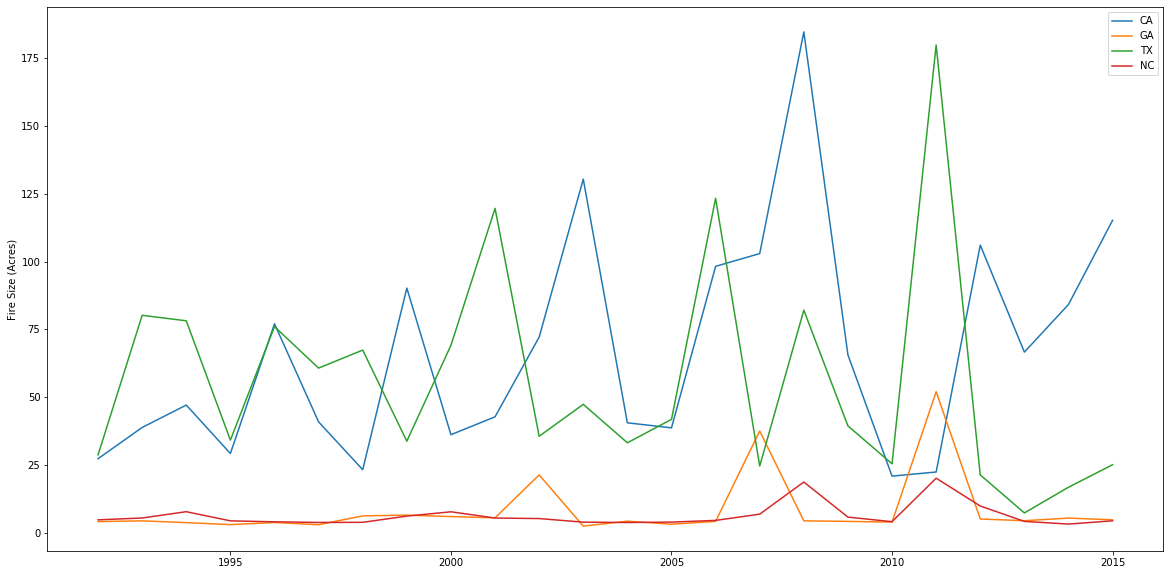

In [20]:
plt.figure(figsize=(20,10))
ca, = plt.plot(years,ca_avg_fire_size,label="CA")
ga, = plt.plot(years,ga_avg_fire_size,label="GA")
tx, = plt.plot(years,tx_avg_fire_size,label="TX")
nc, = plt.plot(years,nc_avg_fire_size,label="NC")

plt.legend(handles=[ca,ga,tx,nc])
plt.ylabel("Fire Size (Acres)")
plt.show()

In [8]:
fire_data_df.STAT_CAUSE_DESCR.value_counts()

Debris Burning       429028
Miscellaneous        323805
Arson                281455
Lightning            278468
Missing/Undefined    166723
Equipment Use        147612
Campfire              76139
Children              61167
Smoking               52869
Railroad              33455
Powerline             14448
Fireworks             11500
Structure              3796
Name: STAT_CAUSE_DESCR, dtype: int64

In [9]:
fire_data_df.FIRE_SIZE_CLASS.value_counts()

B    939376
A    666919
C    220077
D     28427
E     14107
F      7786
G      3773
Name: FIRE_SIZE_CLASS, dtype: int64

In [10]:
fire_data_df.STATE.value_counts()

CA    189550
GA    168867
TX    142021
NC    111277
FL     90261
SC     81315
NY     80870
MS     79230
AZ     71586
AL     66570
OR     61088
MN     44769
OK     43239
MT     40767
NM     37478
ID     36698
CO     34157
WA     33513
WI     31861
AR     31663
TN     31154
SD     30963
UT     30725
LA     30013
KY     27089
NJ     25949
PR     22081
WV     21967
VA     21833
MO     17953
NV     16956
ND     15201
WY     14166
ME     13150
AK     12843
MI     10502
HI      9895
PA      8712
NE      7973
KS      7673
CT      4976
IA      4134
MD      3622
OH      3479
MA      2626
NH      2452
IL      2327
IN      2098
RI       480
VT       456
DE       171
DC        66
Name: STATE, dtype: int64

In [11]:
counties = []
for x in fire_data_df["COUNTY"]:
    if x not in counties and str(x) != 'nan':
        counties.append(x)
len(counties)

3455

In [12]:
states = []
for x in fire_data_df["STATE"]:
    if x not in states and str(x) != 'nan':
        states.append(x)
len(states)

52

In [13]:
# Census API Key
c = Census(census_key, year=2013)

census_data = c.acs5.get(("B01003_001E"), {
                         'for': 'county:*'})
# Convert to DataFrame
census_df = pd.DataFrame(census_data)
census_df

,B01003_001E,state,county
0,9699.0,72,083
1,29086.0,72,011
2,41798.0,72,131
3,204725.0,72,021
4,27669.0,72,033
...,...,...,...
3216,13512.0,54,063
3217,17502.0,54,065
3218,26168.0,54,067
3219,44156.0,54,069


In [14]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [15]:
# Store locations 
fire_locations = fire_data_df[["LATITUDE", "LONGITUDE"]].astype(float)

# Convert to float and store
fire_size = fire_data_df["FIRE_SIZE"].astype(float)

In [16]:
# Create a Heatmap layer
fig = gmaps.figure(map_type="TERRAIN")

In [17]:
fire_layer = gmaps.heatmap_layer(fire_locations, weights=fire_size, 
                                 dissipating=False, max_intensity=1000,
                                 point_radius = .05)

In [18]:
fig.add_layer(fire_layer)

fig

Figure(layout=FigureLayout(height='420px'))